# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 4
# Regularization, High Dimensionality, PCA


**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook even if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately):

Enrollment Status (109A, 121A, 209A, or E109A):

Import libraries:

In [118]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
%matplotlib inline
sns.set_context("poster")

# Continuing Bike Sharing Usage Data

In this homework, we will focus on multiple linear regression, regularization, dealing with high dimensionality, and PCA. We will continue to build regression models for the Capital Bikeshare program in Washington D.C.  See Homework 3 for more information about the data.

*Note: please make sure you use all the processed data from HW 3 Part (a)...you make want to save the data set on your computer and reread the csv/json file here.


In [119]:
# Create Dataframes
trainDf = pd.read_csv("Bikeshare_train.csv")
testDf = pd.read_csv("Bikeshare_test.csv")

# Create dummy variables
trainBinaryDf = pd.get_dummies(trainDf, columns=["season", "month", "day_of_week", "weather"])
testBinaryDf = pd.get_dummies(testDf, columns=["season", "month", "day_of_week", "weather"])

# Normalize predictors
for column in ["temp", "atemp", "humidity", "windspeed"]:
    colMean = np.mean(trainBinaryDf[column])
    colSD = np.std(trainBinaryDf[column])
    trainBinaryDf[column + "_norm"] = [(x - colMean)/float(colSD) for x in trainBinaryDf[column]]
    testBinaryDf[column + "_norm"] = [(x - colMean)/float(colSD) for x in testBinaryDf[column]]
trainBinaryDf.head()

# Drop k-th dummies
predictors = ["holiday", "workingday", "temp_norm","atemp_norm","humidity_norm","windspeed_norm",
              "weather_1.0", "weather_2.0", "day_of_week_0.0", "day_of_week_1.0", "day_of_week_2.0",
              "day_of_week_3.0", "day_of_week_4.0", "day_of_week_5.0", "season_1.0",
              "season_2.0", "season_3.0", "month_2.0", "month_3.0", "month_4.0", "month_5.0",
              "month_6.0", "month_7.0", "month_8.0", "month_9.0", "month_10.0", "month_11.0", "month_12.0", "const"]

# Add a constant term to our predictors
trainBinaryDf = sm.add_constant(trainBinaryDf)
testBinaryDf = sm.add_constant(testBinaryDf)

trainPredict = trainBinaryDf[predictors]
testPredict = testBinaryDf[predictors]

In the above code, we simply prepared our data in the same way that we did in HW3.  

## Part (f): Regularization/Penalization Methods

As an alternative to selecting a subset of predictors and fitting a regression model on the subset, one can fit a linear regression model on all predictors, but shrink or regularize the coefficient estimates to make sure that the model does not "overfit" the training set. 

Use the following regularization techniques to fit linear models to the training set:
- Ridge regression
- Lasso regression
    
You may choose the shrikage parameter $\lambda$ from the set $\{10^{-5}, 10^{-4},...,10^{4},10^{5}\}$ using cross-validation. In each case, 

- How do the estimated coefficients compare to or differ from the coefficients estimated by a plain linear regression (without shrikage penalty) in Part (b) fropm HW 3? Is there a difference between coefficients estimated by the two shrinkage methods? If so, give an explantion for the difference.
- List the predictors that are assigned a coefficient value close to 0 (say < 1e-10) by the two methods. How closely do these predictors match the redundant predictors (if any) identified in Part (c) from HW 3?
- Is there a difference in the way Ridge and Lasso regression assign coefficients to the predictors `temp` and `atemp`? If so, explain the reason for the difference.

We next analyze the performance of the two shrinkage methods for different training sample sizes:
- Generate random samples of sizes 100, 150, ..., 400 from the training set. You may use the following code to draw a random sample of a specified size from the training set:

In [120]:
#--------  sample
# A function to select a random sample of size k from the training set
# Input: 
#      x (n x d array of predictors in training data)
#      y (n x 1 array of response variable vals in training data)
#      k (size of sample) 
# Return: 
#      chosen sample of predictors and responses

def sample(x, y, k):
    n = x.shape[0] # No. of training points
    
    # Choose random indices of size 'k'
    subset_ind = np.random.choice(np.arange(n), k)
    
    # Get predictors and reponses with the indices
    x_subset = x[subset_ind, :]
    y_subset = y[subset_ind]
    
    return (x_subset, y_subset)

- Fit linear, Ridge and Lasso regression models to each of the generated sample. In each case, compute the $R^2$ score for the model on the training sample on which it was fitted, and on the test set.
- Repeat the above experiment for 10 random trials/splits, and compute the average train and test $R^2$ across the trials for each training sample size. Also, compute the standard deviation (SD) in each case.
- Make a plot of the mean training $R^2$ scores for the linear, Ridge and Lasso regression methods as a function of the training sample size. Also, show a confidence interval for the mean scores extending from **mean - SD** to **mean + SD**. Make a similar plot for the test $R^2$ scores.

How do the training and test $R^2$ scores compare for the three methods? Give an explanation for your observations. How do the confidence intervals for the estimated $R^2$ change with training sample size? Based on the plots, which of the three methods would you recommend when one needs to fit a regression model using a small training sample?

*Hint:* You may use `sklearn`'s `RidgeCV` and `LassoCV` classes to implement Ridge and Lasso regression. These classes automatically perform cross-validation to tune the parameter $\lambda$ from a given range of values. You may use the `plt.errorbar` function to plot confidence bars for the average $R^2$ scores.

In [121]:
# Lambdas
lambdas = [10**x for x in range(-5, 6)]
xTrain = trainPredict
yTrain = trainBinaryDf["count"]

ridgeCoefs = []
lassoCoefs = []

# Regression on entire training data set
ridge = RidgeCV(alphas=lambdas, cv=10, fit_intercept=True)
ridge.fit(xTrain, yTrain)

ridgeCoefs = ridge.coef_

lasso = LassoCV(alphas=lambdas, cv=10, max_iter=10000, fit_intercept=True)
lasso.fit(xTrain, yTrain)

lassoCoefs = lasso.coef_


In [122]:
HW3Model = sm.OLS(yTrain, xTrain).fit()
HW3Coefs = HW3Model.params


In [123]:
r2TrainVals = pd.DataFrame(data={"Original": [.576], "Lasso": [lasso.score(xTrain, yTrain)],
                            "Ridge": [ridge.score(xTrain, yTrain)]})
r2TrainVals

,Lasso,Original,Ridge
0,0.563605,0.576,0.559563


In [124]:
r2TestVals = pd.DataFrame(data={"Original": [.249], "Lasso": [lasso.score(xTest, yTest)],
                            "Ridge": [ridge.score(xTest, yTest)]})
r2TestVals

,Lasso,Original,Ridge
0,0.263547,0.249,0.256219


In [125]:
ridgeCoefs[-1] = ridge.intercept_
lassoCoefs[-1] = lasso.intercept_
coefsTable = pd.DataFrame(data={"HW3Model": HW3Coefs, "RidgeModel": ridgeCoefs, "LassoModel": lassoCoefs})
coefsTable.head(50)

,HW3Model,LassoModel,RidgeModel
holiday,-616.602710,-171.307907,-235.657032
workingday,-24.093294,0.000000,28.943832
temp_norm,924.334403,615.501808,596.419466
atemp_norm,311.961760,473.093575,531.323759
humidity_norm,-547.663783,-556.194283,-558.385010
windspeed_norm,-254.736916,-246.996085,-264.834036
weather_1.0,1581.978284,759.077243,480.235213
weather_2.0,1565.411700,731.541784,452.456290
day_of_week_0.0,-465.145010,-293.747624,-268.575304
day_of_week_1.0,-256.650051,-204.727796,-203.553159


In [126]:
xTest = testPredict
yTest = testBinaryDf["count"]

In [127]:
def randSampleR2(k):
    """k is the sample size
    outputs R2 values for linear, lasso, ridge regression models"""
    
    xSub, ySub = sample(xTrain.as_matrix(), yTrain.as_matrix(), k)
    
    ridge = RidgeCV(alphas=lambdas, cv=10, fit_intercept=True)
    ridge.fit(xSub, ySub)
    
    lasso = LassoCV(alphas=lambdas, cv=10, fit_intercept=True, max_iter=10000)
    lasso.fit(xSub, ySub)
    
    linear = sm.OLS(ySub, xSub).fit()
    
    yHat = linear.predict(xTest)
    
    
    return linear.rsquared, lasso.score(xSub, ySub), ridge.score(xSub, ySub), \
           r2_score(yTest, yHat), lasso.score(xTest, yTest), ridge.score(xTest, yTest)

In [128]:
sampleSizes = np.arange(100, 450, 50)

rSquaredBootStrap = {"sampleSize": sampleSizes, "linearTrain": [], "lassoTrain": [],
                     "ridgeTrain": [], "linearTest": [], "lassoTest": [], "ridgeTest": []}
for k in sampleSizes:
    linearTestR2 = []
    lassoTestR2 = []
    ridgeTestR2 = []
    linearTrainR2 = []
    lassoTrainR2 = []
    ridgeTrainR2 = []
    for _ in range(10):
        linTrain, lasTrain, ridTrain, linTest, lasTest, ridTest = randSampleR2(k)
        linearTrainR2.append(linTrain)
        lassoTrainR2.append(lasTrain)
        ridgeTrainR2.append(ridTrain)
        linearTestR2.append(linTest)
        lassoTestR2.append(lasTest)
        ridgeTestR2.append(ridTest)
        
    rSquaredBootStrap["linearTrain"].append(linearTrainR2)
    rSquaredBootStrap["lassoTrain"].append(lassoTrainR2)
    rSquaredBootStrap["ridgeTrain"].append(ridgeTrainR2)
    rSquaredBootStrap["linearTest"].append(linearTestR2)
    rSquaredBootStrap["lassoTest"].append(lassoTestR2)
    rSquaredBootStrap["ridgeTest"].append(ridgeTestR2)

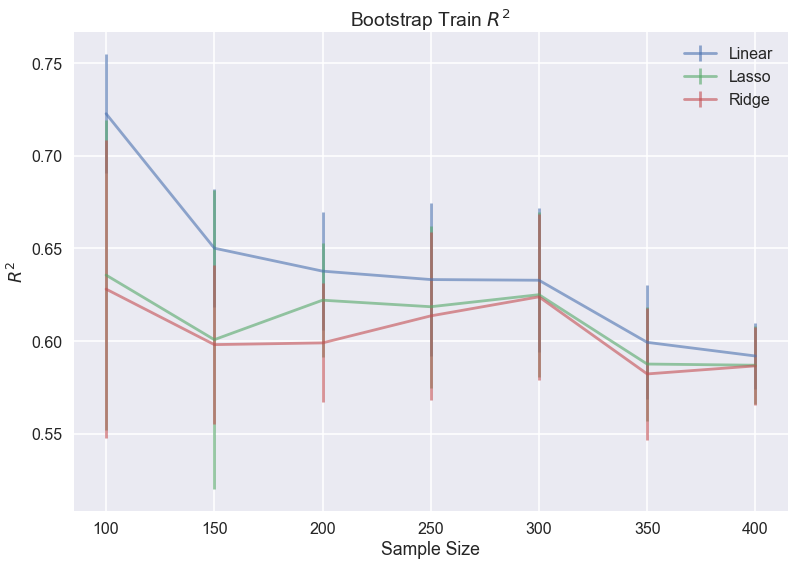

In [129]:
fig, ax = plt.subplots()

linTrainMeans = [np.mean(x) for x in rSquaredBootStrap["linearTrain"]]
linTrainSDs = [np.std(x) for x in rSquaredBootStrap["linearTrain"]]
lasTrainMeans = [np.mean(x) for x in rSquaredBootStrap["lassoTrain"]]
lasTrainSDs = [np.std(x) for x in rSquaredBootStrap["lassoTrain"]]
ridTrainMeans = [np.mean(x) for x in rSquaredBootStrap["ridgeTrain"]]
ridTrainSDs = [np.std(x) for x in rSquaredBootStrap["ridgeTrain"]]

ax.set_title("Bootstrap Train $R^2$")
ax.set_xlabel("Sample Size")
ax.set_ylabel("$R^2$")

ax.errorbar(rSquaredBootStrap["sampleSize"], linTrainMeans, linTrainSDs, label="Linear", alpha=.6)
ax.errorbar(rSquaredBootStrap["sampleSize"], lasTrainMeans, lasTrainSDs, label="Lasso", alpha=.6)
ax.errorbar(rSquaredBootStrap["sampleSize"], ridTrainMeans, ridTrainSDs, label="Ridge", alpha=.6)
ax.legend()


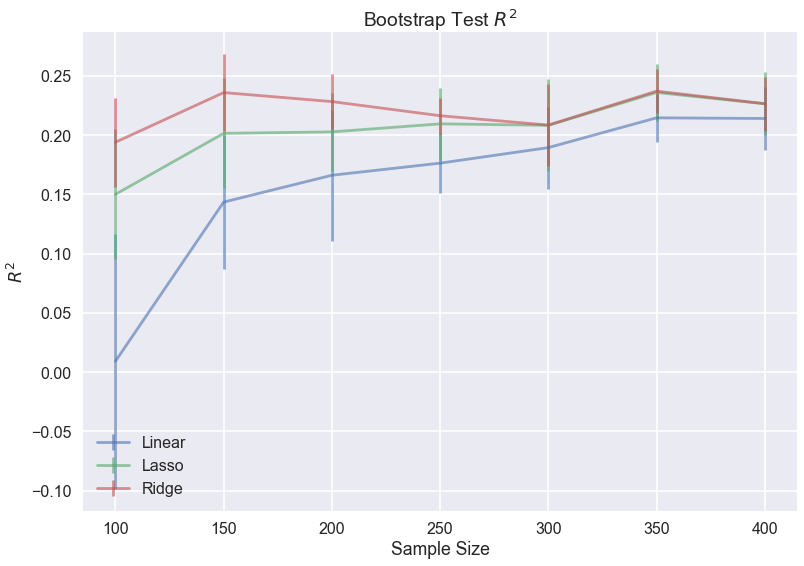

In [130]:
fig, ax = plt.subplots()

linTestMeans = [np.mean(x) for x in rSquaredBootStrap["linearTest"]]
linTestSDs = [np.std(x) for x in rSquaredBootStrap["linearTest"]]
lasTestMeans = [np.mean(x) for x in rSquaredBootStrap["lassoTest"]]
lasTestSDs = [np.std(x) for x in rSquaredBootStrap["lassoTest"]]
ridTestMeans = [np.mean(x) for x in rSquaredBootStrap["ridgeTest"]]
ridTestSDs = [np.std(x) for x in rSquaredBootStrap["ridgeTest"]]

ax.set_title("Bootstrap Test $R^2$")
ax.set_xlabel("Sample Size")
ax.set_ylabel("$R^2$")

ax.errorbar(rSquaredBootStrap["sampleSize"], linTestMeans, linTestSDs, label="Linear", alpha=.6)
ax.errorbar(rSquaredBootStrap["sampleSize"], lasTestMeans, lasTestSDs, label="Lasso", alpha=.6)
ax.errorbar(rSquaredBootStrap["sampleSize"], ridTestMeans, ridTestSDs, label="Ridge", alpha=.6)
ax.legend()

## Response to above questions

- How do the estimated coefficients compare to or differ from the coefficients estimated by a plain linear regression (without shrikage penalty) in Part (b) fropm HW 3? Is there a difference between coefficients estimated by the two shrinkage methods? If so, give an explantion for the difference.

As we can see from the data table above, the magnitude of our Lasso and Ridge coefficients are significantly and consistently smaller than those of our HW3 model.  This is exactly the behavior we would expect, as Lasso and Ridge methods try to decrease the magnitude of our coefficients by adding a cost term for the L1 or L2 of our $\beta$.


- List the predictors that are assigned a coefficient value close to 0 (say < 1e-10) by the two methods. How closely do these predictors match the redundant predictors (if any) identified in Part (c) from HW 3?

Lasso Model: *working_day*, *day_of_week_4.0*, *season_2.0*, *month_2.0*, *month_5.0*, *month_12.0*.  We note that there are no coefficient values close to 0 in either Ridge or our HW3 models.  This makes sense, as shown in class, that it is more likely for the L1 norm cost function to result in coefficients of value 0 than for L2 norm.   

- Is there a difference in the way Ridge and Lasso regression assign coefficients to the predictors `temp` and `atemp`? If so, explain the reason for the difference.

Both Ridge and Lasso regression preserves the initial relationship observed in HW3, that *temp* has a larger coefficient value than *atemp*.  However, what is interesting to note is that the difference between these coefficients seem to converge to 0 as our cost term increases its $L^i$ dimensional norm.  For example, for Lasso in L1, the difference is much larger than for Ridge, which uses $L^2$.  

- How do the training and test $R^2$ scores compare for the three methods? Give an explanation for your observations. How do the confidence intervals for the estimated $R^2$ change with training sample size? Based on the plots, which of the three methods would you recommend when one needs to fit a regression model using a small training sample?

We notice that the training $R^2$ values for both Lasso and Ridge are lower than our HW3 model, which is to be expected as we are introducing a regularization parameter.  However, our Lasso and Ridge models perform better on the test data than our HW3 model, implying that we have successfully mitigated some of the overfitting from our HW3 model. 

The confidence intervals for the estimated $R^2$ tend to decrease as our sample size grows.  While there are some fluctuations in the above graphs, we note that this overall trend of decreasing confidence intervals seems to dominate over all three models.  

If we had to choose one of the three models given a small training sample, we would select the Ridge regression model.  It has the smallest standard deviation in its $R^2$ scores, and consistently outperforms the other two models over many small sample sizes. 

## Part (g): Polynomial & Interaction Terms

Moving beyond linear models, we will now try to improve the performance of the regression model in Part (b) from HW 3 by including higher-order polynomial and interaction terms. 

- For each continuous predictor $X_j$, include additional polynomial terms $X^2_j$, $X^3_j$, and $X^4_j$, and fit a multiple regression model to the expanded training set. How does the $R^2$ of this model on the test set compare with that of the linear model fitted in Part (b) from HW 3? Using a t-test, find out which of estimated coefficients for the polynomial terms are statistically significant at a significance level of 5%. 

- Fit a multiple linear regression model with additional interaction terms $\mathbb{I}_{month = 12} \times temp$ and $\mathbb{I}_{workingday = 1} \times \mathbb{I}_{weathersit = 1}$ and report the test $R^2$ for the fitted model. How does this compare with the $R^2$ obtained using linear model in Part (b) from HW 3? Are the estimated coefficients for the interaction terms statistically significant at a significance level of 5%?

In [131]:
# Generate polynomial features
multTrainPredict = trainPredict.copy()
multTestPredict = testPredict.copy()

for i in range(2,5):
    for var in ["temp_norm", "atemp_norm", "humidity_norm", "windspeed_norm"]:
        multTrainPredict["{}_{}".format(var, i)] = multTrainPredict[var]**i
        multTestPredict["{}_{}".format(var, i)] = multTestPredict[var]**i

In [132]:
# Fit OLS model
multModel = sm.OLS(yTrain, multTrainPredict).fit()
multModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     15.13
Date:                Tue, 10 Oct 2017   Prob (F-statistic):           7.98e-50
Time:                        01:13:03   Log-Likelihood:                -2790.9
No. Observations:                 331   AIC:                             5662.
Df Residuals:                     291   BIC:                             5814.
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
holiday           -526.2557    372.773     -1.412      0.159   -1259.929     207.418
workingday          14.7858    159.059      0.093      0.926    -298.265     327.837
temp_norm          770.3204    758.967      1.015      0.311    -723.441    2264.082
atemp_norm         895.9192    712.094      1.258      0.209    -505.588    2297.426
humidity_norm     -667.9033    157.118     -4.251      0.000    -977.136    -358.671
windspeed_norm    -445.8335    148.704     -2.998      0.003    -738.505    -153.162
weather_1.0       1043.9997    546.051      1.912      0.057     -30.710    2118.709
weather_2.0       1103.0116    499.023      2.210      0.028     120.859    2085.164
day_of_week_0.0   -471.0834    246.557     -1.911      0.057    -956.345      14.178
day_of_week_1.0   -227.9217    157.372     -1.448      0.149    -537.653      81.809
day_of_week_2.0   -268.0232    186.488     -1.437      0.152    -635.060      99.014
day_of_week_3.0     13.1360    196.966      0.067      0.947    -374.522     400.794
day_of_week_4.0   -104.0028    189.352     -0.549      0.583    -476.675     268.669
day_of_week_5.0     75.3419    184.193      0.409      0.683    -287.178     437.861
season_1.0       -1523.2288    467.580     -3.258      0.001   -2443.496    -602.961
season_2.0        -756.7981    536.808     -1.410      0.160   -1813.316     299.720
season_3.0          55.5255    419.974      0.132      0.895    -771.046     882.097
month_2.0         -325.0686    409.611     -0.794      0.428   -1131.245     481.108
month_3.0         -304.8491    446.028     -0.683      0.495   -1182.700     573.002
month_4.0         -418.0245    639.524     -0.654      0.514   -1676.703     840.654
month_5.0        -1037.2042    677.186     -1.532      0.127   -2370.008     295.599
month_6.0        -1456.1857    697.520     -2.088      0.038   -2829.010     -83.362
month_7.0        -1416.9882    749.751     -1.890      0.060   -2892.610      58.634
month_8.0        -1715.9389    743.240     -2.309      0.022   -3178.747    -253.131
month_9.0        -1073.4008    660.859     -1.624      0.105   -2374.069     227.268
month_10.0        -925.8710    617.522     -1.499      0.135   -2141.247     289.505
month_11.0        -825.5328    591.138     -1.397      0.164   -1988.981     337.916
month_12.0        -555.6676    479.543     -1.159      0.248   -1499.481     388.146
const             5985.5838    836.335      7.157      0.000    4339.552    7631.616
temp_norm_2      -1805.5466    814.442     -2.217      0.027   -3408.491    -202.602
atemp_norm_2      1171.9491    786.481      1.490      0.137    -375.962    2719.861
humidity_norm_2    -53.5087    154.914     -0.345      0.730    -358.402     251.384
windspeed_norm_2   -34.0621    126.569     -0.269      0.788    -283.168     215.044
temp_norm_3          8.

In [133]:
yHatTest = multModel.predict(multTestPredict)
r2_score(yTest, yHatTest)

0.27723843508616397

In [134]:
# Generate additional interaction features
intTrainPredict = multTrainPredict.copy()
intTestPredict = multTestPredict.copy()

# Add month=12 x temp interaction terms
intTrainPredict["month_12xtemp_norm"] = intTrainPredict["month_12.0"] * intTrainPredict["temp_norm"]
intTestPredict["month_12xtemp_norm"] = intTestPredict["month_12.0"] * intTestPredict["temp_norm"]

# Add workingday x weathersit=1 interaction terms
intTrainPredict["workingdayxweather_1"] = intTrainPredict["workingday"] * intTrainPredict["weather_1.0"]
intTestPredict["workingdayxweather_1"] = intTestPredict["workingday"] * intTestPredict["weather_1.0"]

In [135]:
# Fit Interaction OLS model
intModel = sm.OLS(yTrain, intTrainPredict).fit()
intModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     14.31
Date:                Tue, 10 Oct 2017   Prob (F-statistic):           1.07e-48
Time:                        01:13:03   Log-Likelihood:                -2790.7
No. Observations:                 331   AIC:                             5665.
Df Residuals:                     289   BIC:                             5825.
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
holiday               -504.8692    376.774     -1.340      0.181   -1246.437     236.699
workingday             -78.3221    242.127     -0.323      0.747    -554.878     398.234
temp_norm              793.8768    763.389      1.040      0.299    -708.631    2296.385
atemp_norm             880.3824    715.945      1.230      0.220    -528.745    2289.510
humidity_norm         -675.3295    158.264     -4.267      0.000    -986.826    -363.833
windspeed_norm        -446.4038    149.948     -2.977      0.003    -741.532    -151.276
weather_1.0            923.0406    594.656      1.552      0.122    -247.366    2093.447
weather_2.0           1104.9141    502.004      2.201      0.029     116.866    2092.962
day_of_week_0.0       -462.4486    248.640     -1.860      0.064    -951.824      26.926
day_of_week_1.0       -239.5854    159.457     -1.503      0.134    -553.429      74.259
day_of_week_2.0       -280.3233    188.566     -1.487      0.138    -651.459      90.813
day_of_week_3.0         -3.0325    200.247     -0.015      0.988    -397.160     391.095
day_of_week_4.0       -119.9933    192.772     -0.622      0.534    -499.408     259.422
day_of_week_5.0         59.7432    187.628      0.318      0.750    -309.547     429.033
season_1.0           -1493.1626    505.353     -2.955      0.003   -2487.801    -498.524
season_2.0            -729.5247    549.124     -1.329      0.185   -1810.315     351.266
season_3.0              71.1170    422.825      0.168      0.867    -761.090     903.324
month_2.0             -325.7395    415.794     -0.783      0.434   -1144.107     492.628
month_3.0             -311.7359    465.982     -0.669      0.504   -1228.885     605.413
month_4.0             -429.5823    676.680     -0.635      0.526   -1761.428     902.264
month_5.0            -1024.8594    711.364     -1.441      0.151   -2424.970     375.251
month_6.0            -1466.6541    734.348     -1.997      0.047   -2912.002     -21.306
month_7.0            -1427.6739    798.423     -1.788      0.075   -2999.136     143.788
month_8.0            -1720.6375    791.728     -2.173      0.031   -3278.922    -162.353
month_9.0            -1055.9093    726.079     -1.454      0.147   -2484.983     373.165
month_10.0            -882.2336    692.220     -1.274      0.204   -2244.665     480.198
month_11.0            -773.6133    656.762     -1.178      0.240   -2066.257     519.030
month_12.0            -480.9222   1027.332     -0.468      0.640   -2502.924    1541.080
const                 6035.4428    902.323      6.689      0.000    4259.486    7811.400
temp_norm_2          -1796.4144    817.390     -2.198      0.029   -3405.207    -187.621
atemp_norm_2          1167.1361    790.067      1.477      0.141    -387.880    2722.152
humidity_norm_2        -56.3479    155.509     -0.362    

In [136]:
yHatTest = intModel.predict(intTestPredict)
r2_score(yTest, yHatTest)

0.28297793302407059

## Answers to Above Questions
- For each continuous predictor $X_j$, include additional polynomial terms $X^2_j$, $X^3_j$, and $X^4_j$, and fit a multiple regression model to the expanded training set. How does the $R^2$ of this model on the test set compare with that of the linear model fitted in Part (b) from HW 3? Using a t-test, find out which of estimated coefficients for the polynomial terms are statistically significant at a significance level of 5%. 

We found that the $R^2$ of this model was .277 for the test data set, which clearly outperforms the $R^2$ score of our HW3 model on the test data set of .249.  Using the t-tests provided in the summary above, we found that the only statistically significant coefficient was *temp_norm_2*, which equates to $X^2$ where $X$ is the normalized continuous variable for temperature.  

- Fit a multiple linear regression model with additional interaction terms $\mathbb{I}_{month = 12} \times temp$ and $\mathbb{I}_{workingday = 1} \times \mathbb{I}_{weathersit = 1}$ and report the test $R^2$ for the fitted model. How does this compare with the $R^2$ obtained using linear model in Part (b) from HW 3? Are the estimated coefficients for the interaction terms statistically significant at a significance level of 5%?

For this additional model, we found that the $R^2$ score on the test set was .283, even better than our previous model of .277, and much better than the HW3 model of .249.  There are no statistically significant interaction coefficients, as their 95% confidence intervals, as shown above, include 0.  

## Part (h): PCA to deal with high dimensionality

We would like to fit a model to include all main effects, polynomial terms up to the $4^{th}$ order, and all interactions between all possible predictors and polynomial terms (not including the interactions between $X^1_j$, $X^2_j$, $X^3_j$, and $X^4_j$ as they would just create higher order polynomial terms).  

- Create an expanded training set including all the desired terms mentioned above.  What are the dimensions of this 'design matrix' of all the predictor variables?   What are the issues with attempting to fit a regression model using all of these predictors?

- Instead of using the usual approaches for model selection, let's instead use principal components analysis (PCA) to fit the model.  First, create the principal component vectors in python (consider: should you normalize first?).  Then fit 5 different regression models: (1) using just the first PCA vector, (2) using the first two PCA vectors, (3) using the first three PCA vectors, etc...  Briefly summarize how these models compare in the training set.

- Use the test set to decide which of the 5 models above is best to predict out of sample.  How does this model compare to the previous models you've fit?  What are the interpretations of this model's coefficients?

In [137]:
xTest = testPredict
yTest = testBinaryDf["count"]

xTrain = trainPredict
yTrain = trainBinaryDf["count"]

genPolyTerms = PolynomialFeatures(degree=4, interaction_only=False)

xTrainPoly = []
xTestPoly = []

xTrainPoly.append(genPolyTerms.fit_transform(xTrain))
xTestPoly.append(genPolyTerms.fit_transform(xTest))

print("There are {} predictors in this new design matrix.".format(xTrainPoly[0].shape[1]))

There are 40920 predictors in this new design matrix.


In [138]:
pcaXTrainVals = []
pcaXTestVals = []
for i in range(1,6):
    pca = PCA(n_components=i)
    pca.fit(xTrainPoly[0])
    xPCA = pca.transform(xTrainPoly[0])
    xTestPCA = pca.transform(xTestPoly[0])
    pcaXTrainVals.append(xPCA)
    pcaXTestVals.append(xTestPCA)

In [139]:
trainPCAModels = []
r2sTrain = []
r2sTest = []

for i, data in enumerate(pcaXTrainVals):
    regPCAModel = LinearRegression(fit_intercept=True)
    regPCAModel.fit(data, yTrain)
    r2sTrain.append(regPCAModel.score(data, yTrain))
    r2sTest.append(regPCAModel.score(pcaXTestVals[i], yTest))
    trainPCAModels.append(regPCAModel)

([0.12699183896543709,
  0.17662017530962659,
  0.24654453857588476,
  0.28015860164172535,
  0.34565326181924971],
 [0.071563783094968247,
  0.14324347582397357,
  0.17721909976741482,
  0.14924023431953759,
  0.13943164222869453])

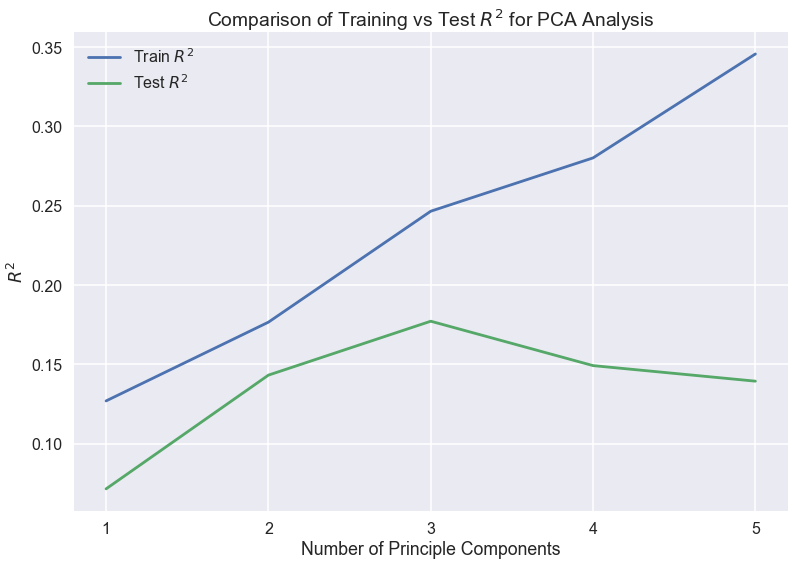

In [140]:
fig, ax = plt.subplots()
ax.plot(range(1,6), r2sTrain, label="Train $R^2$")
ax.plot(range(1,6), r2sTest, label="Test $R^2$")
ax.set_xlabel("Number of Principle Components")
ax.set_ylabel("$R^2$")
ax.set_title("Comparison of Training vs Test $R^2$ for PCA Analysis")
plt.xticks(range(1,6), )
ax.legend()

r2sTrain, r2sTest

In [141]:
pcaGoalModel = trainPCAModels[2]
print("The coefficients are: {}.".format(pcaGoalModel.coef_))
print("The intercept is: {}.".format(pcaGoalModel.intercept_))

The coefficients are: [-34.95509138 -32.72310645  48.22780406].
The intercept is: 4598.447129909366.


## Answers to Above Questions
- Create an expanded training set including all the desired terms mentioned above.  What are the dimensions of this 'design matrix' of all the predictor variables?   What are the issues with attempting to fit a regression model using all of these predictors?

We can see that there are 40,920 predictor variables in this new design matrix, with 331 rows.  One major reason why we would not want to fit a model with this many predictors is because the number of predictors is larger than the number of data points, implying that our model will completely overfit our data.  Additionally, we will have collinearity, and model selection (applying stepwise forward algorithms) become intractable.  

- Instead of using the usual approaches for model selection, let's instead use principal components analysis (PCA) to fit the model.  First, create the principal component vectors in python (consider: should you normalize first?).  Then fit 5 different regression models: (1) using just the first PCA vector, (2) using the first two PCA vectors, (3) using the first three PCA vectors, etc...  Briefly summarize how these models compare in the training set.

From the above plot, we can see that as the number of principle components included in our model increases, our training $R^2$ monotonically increases.  This makes sense, as we are doing a better job at capturing the variance in our training data with each additional principle component.  However, for the test data, we find that we begin to overfit our training data after including the 3 most significant components.  This is seen by the concave line plot for the test data above.  

- Use the test set to decide which of the 5 models above is best to predict out of sample.  How does this model compare to the previous models you've fit?  What are the interpretations of this model's coefficients?

From the above, we find that it is best to select the model with 3 principle components.  This model is much worse than our previous models, with a $R^2$ for the test data set of .177.  There are no obvious interpretations of this model's coefficients, other than the weightings of each principle component vector.   These weightings are [-34.95509138 -32.72310589  48.22779733] respectively.  Further, we have a very large positive intercept of 4598.447129909366.  

## Part (i): Beyond Squared Error

We have seen in class that the multiple linear regression method optimizes the Mean Squared Error (MSE) on the training set. Consider the following alternate evaluation metric, referred to as the Root Mean Squared Logarthmic Error (RMSLE):

$$
\sqrt{\frac{1}{n}\sum_{i=1}^n (log(y_i+1) - log(\hat{y}_i+1))^2}.
$$

The *lower* the RMSLE the *better* is the performance of a model. The RMSLE penalizes errors on smaller responses more heavily than errors on larger responses. For example, the RMSLE penalizes a prediction of $\hat{y} = 15$ for a true response of $y=10$ more heavily than a prediction of $\hat{y} = 105$ for a true response of $100$, though the difference in predicted and true responses are the same in both cases. 

This is a natural evaluation metric for bike share demand prediction, as in this application, it is more important that the prediction model is accurate on days where the demand is low (so that the few customers who arrive are served satisfactorily), compared to days on which the demand is high (when it is less damaging to lose out on some customers).

The following code computes the RMSLE for you:

In [142]:
#--------  rmsle
# A function for evaluating Root Mean Squared Logarithmic Error (RMSLE)
# of the linear regression model on a data set
# Input: 
#      y_test (n x 1 array of response variable vals in testing data)
#      y_pred (n x 1 array of response variable vals in testing data)
# Return: 
#      RMSLE (float) 

def rmsle(y, y_pred):     
    # Evaluate sqaured error, against target labels
    # rmsle = \sqrt(1/n \sum_i (log (y[i]+1) - log (y_pred[i]+1))^2)
    rmsle_ = np.sqrt(np.mean(np.square(np.log(y+1) - np.log(y_pred+1))))
    
    return rmsle_

Use the above code to compute the training and test RMSLE for the polynomial regression model you fit in Part (g). 

You are required to develop a strategy to fit a regression model by optimizing the RMSLE on the training set. Give a justification for your proposed approach. Does the model fitted using your approach yield lower train RMSLE than the model in Part (g)? How about the test RMSLE of the new model? 

**Note:** We do not require you to implement a new regression solver for RMSLE. Instead, we ask you to think about ways to use existing built-in functions to fit a model that performs well on RMSLE. Your regression model may use the same polynomial terms used in Part (g).

In [143]:
# your code here
yTest = testBinaryDf["count"]

yHatTest = multModel.predict(multTestPredict)
print("RMSLE for the model in part g: {}".format(rmsle(yTest, yHatTest)))



RMSLE for the model in part g: 0.5242723327381363


/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]


In [144]:
X = multTrainPredict.copy()
Y = yTrain

newModel = sm.OLS(list(Y), X).fit()
yHat = newModel.predict(X)

error = np.abs(yHat - Y)

Y = Y.reindex([error.argsort()])
X = X.reindex([error.argsort()])

X_aug = X
Y_aug = Y

for _ in range(400):
    X_aug = X_aug.append(X[:50])
    Y_aug = Y_aug.append(Y[:50])

newModel = sm.OLS(list(Y_aug), X_aug).fit()
yHat = newModel.predict(multTestPredict)
rmsleVal = rmsle(yTest, yHat)
print("Our new RMSLE is: {}.".format(rmsleVal))

Our new RMSLE is: 0.5051747912721489.


/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]


## Answers to Above Questions
- You are required to develop a strategy to fit a regression model by optimizing the RMSLE on the training set. Give a justification for your proposed approach. Does the model fitted using your approach yield lower train RMSLE than the model in Part (g)? How about the test RMSLE of the new model? 

Our strategy to fit a regression model to optimize RMSLE on the training set was the following.  We recognized that data points with small absolute errors in an initial fitting of our training data set would decrease the RMSLE.  Therefore, we augmented our training data by including data points with small absolute residuals multiple times.  This approach intuitively makes sense, as small $|\hat{Y} - Y| \Rightarrow \ln(\hat{Y}+1 ) - \ln(Y+1)$ will also be small, decreasing our overall RMSLE.  

Our new model has an $RMSLE$ value on the test data of .505, which is better than our previous model from part (g)'s score of .524.  

## Part (j): Dealing with Erroneous Labels

Due to occasional system crashes, some of the bike counts reported in the data set have been recorded manually. These counts are not very unreliable and are prone to errors. It is known that roughly 5% of the labels in the training set are erroneous (i.e. can be arbitrarily different from the true counts), while all the labels in the test set were confirmed to be accurate. Unfortunately, the identities of the erroneous records in the training set are not available. Can this information about presence of 5% errors in the training set labels (without details about the specific identities of the erroneous rows) be used to improve the performance of the model in Part (g)? Note that we are interested in improving the $R^2$ performance of the model on the test set (not the training $R^2$ score). 

As a final task, we require you to come up with a strategy to fit a regression model, taking into account the errors in the training set labels. Explain the intuition behind your approach (we do not expect a detailed mathematical justification). Use your approach to fit a regression model on the training set, and compare its test $R^2$ with the model in Part (g).

**Note:** Again, we do not require you to implement a new regression solver for handling erroneous labels. It is sufficient that you to come up with an approach that uses existing built-in functions. Your regression model may use the same polynomial terms used in Part (g).

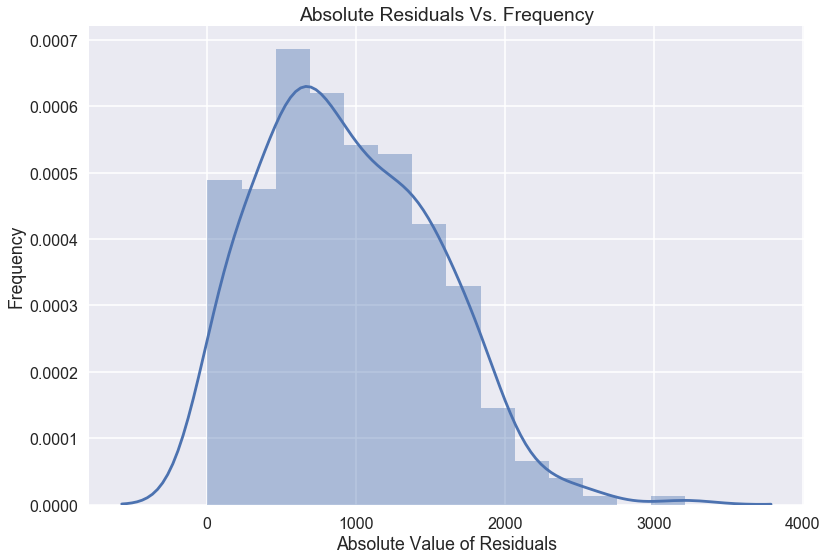

In [149]:
# identify absolute error

multModel = sm.OLS(yTrain, multTrainPredict).fit()
yHatTrain = multModel.predict(multTrainPredict)

errors =  yTrain - yHatTrain
abserrors = np.array(abs(errors))

fig, ax = plt.subplots(1)
ax.set_title("Absolute Residuals Vs. Frequency")
ax.set_ylabel("Frequency")
ax.set_xlabel("Absolute Value of Residuals")
sns.distplot(abserrors)

In [150]:
dropIndices = abserrors.argsort()[-int(len(abserrors)*0.05):][::-1]

adjYTrain = yTrain.drop(yTrain.index[dropIndices])
adjXTrain = multTrainPredict.drop(multTrainPredict.index[dropIndices])
adjMultModel = sm.OLS(adjYTrain, adjXTrain).fit()
adjMultModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     17.93
Date:                Tue, 10 Oct 2017   Prob (F-statistic):           3.05e-55
Time:                        01:15:31   Log-Likelihood:                -2625.6
No. Observations:                 315   AIC:                             5331.
Df Residuals:                     275   BIC:                             5481.
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
holiday            -89.0664    363.130     -0.245      0.806    -803.935     625.802
workingday          85.7392    152.585      0.562      0.575    -214.643     386.122
temp_norm          753.7641    698.454      1.079      0.281    -621.233    2128.761
atemp_norm         931.9529    655.442      1.422      0.156    -358.368    2222.274
humidity_norm     -695.2858    144.789     -4.802      0.000    -980.322    -410.250
windspeed_norm    -443.0108    138.341     -3.202      0.002    -715.353    -170.669
weather_1.0       1007.8855    509.110      1.980      0.049       5.638    2010.133
weather_2.0       1082.5915    463.259      2.337      0.020     170.607    1994.576
day_of_week_0.0   -340.7946    232.970     -1.463      0.145    -799.425     117.836
day_of_week_1.0   -202.8532    149.029     -1.361      0.175    -496.235      90.529
day_of_week_2.0   -207.6025    172.805     -1.201      0.231    -547.791     132.586
day_of_week_3.0    138.3122    184.038      0.752      0.453    -223.990     500.615
day_of_week_4.0    112.0110    185.816      0.603      0.547    -253.791     477.813
day_of_week_5.0    156.8052    172.188      0.911      0.363    -182.168     495.779
season_1.0       -1662.8420    429.543     -3.871      0.000   -2508.452    -817.232
season_2.0        -675.8582    493.064     -1.371      0.172   -1646.518     294.802
season_3.0         226.2033    385.309      0.587      0.558    -532.326     984.733
month_2.0         -248.0666    388.167     -0.639      0.523   -1012.224     516.091
month_3.0         -440.3675    425.067     -1.036      0.301   -1277.166     396.430
month_4.0         -492.6351    603.950     -0.816      0.415   -1681.588     696.318
month_5.0        -1301.7164    635.376     -2.049      0.041   -2552.536     -50.897
month_6.0        -1853.3696    656.642     -2.822      0.005   -3146.053    -560.686
month_7.0        -1693.9734    701.678     -2.414      0.016   -3075.316    -312.631
month_8.0        -2041.3922    699.262     -2.919      0.004   -3417.979    -664.805
month_9.0        -1316.2651    617.398     -2.132      0.034   -2531.692    -100.838
month_10.0       -1272.8666    574.251     -2.217      0.027   -2403.353    -142.380
month_11.0        -960.2166    550.751     -1.743      0.082   -2044.441     124.008
month_12.0        -618.9551    447.518     -1.383      0.168   -1499.952     262.042
const             6165.5547    779.588      7.909      0.000    4630.837    7700.273
temp_norm_2      -2178.4066    754.456     -2.887      0.004   -3663.650    -693.163
atemp_norm_2      1441.5058    728.145      1.980      0.049       8.060    2874.952
humidity_norm_2    -72.8165    143.386     -0.508      0.612    -355.090     209.457
windspeed_norm_2   -70.4969    116.980     -0.603      0.547    -300.787     159.793
temp_norm_3         28.

In [148]:
yHatAdjTest = adjMultModel.predict(multTestPredict)
r2_score(yTest, yHatAdjTest)

0.26553825406157139

## Answer to Above Questions

- As a final task, we require you to come up with a strategy to fit a regression model, taking into account the errors in the training set labels. Explain the intuition behind your approach (we do not expect a detailed mathematical justification). Use your approach to fit a regression model on the training set, and compare its test $R^2$ with the model in Part (g).

Our strategy for the above problem was the following.  We wanted to find the values in our training data set where the absolute value of their residuals were particularly large.  By excluding the top 5% largest absolute residuals, we ensure that any erroneous entries are not outliers skewing our model unfavorably.  We recognize that there is a chance we have not removed exactly all of the errors, but in the event that the errors are clustered with the majority of our correct data, our model should still accurately predict our training data set.  
This hypothesis is supported by the fact that our $R^2$ on the test data set did not significantly decrease from our previous model with the outliers in the training data set.  Our new $R^2$ is .266, which is slightly lower than .277 from our model in part $g$.  